# [Notebook 04] Dense Layer and Weight Initialization

The concept of a __Dense node/layer__ has been mentioned more than a few times now, and in this notebook we'll finally be implementing it and using it to build a __Multi-Layer Perceptron__ - a small fully-connected neural network.

Before we get started, we'll also occasionally define some __utility functions__ that are pretty self-explanatory but handy nonetheless.
- `wrap` "wraps" ints, floats, and Scalars in a list

In [1]:
# kaitorch/utils.py

def wrap(x):

    from kaitorch.core import Scalar

    if isinstance(x, (int, float, Scalar)):
        x = [x]
    return x

# Dense Node

As mentioned before, a node is like the "basic compute unit" of a neural network. Each node takes a set of inputs and generates an output.

In particular, __a Dense node does the following:__
 - 1) Calculates the dot product between a list of inputs and the node weights (also known as the weighted sum of inputs)

 - 2) Adds a bias term to the weighted sum of inputs

 - 3) Applies an activation function and outputs the value

$$ \text{output} = \text{Dense}(\text{inputs}) = \text{Activation}(\text{bias} + \sum_{\text{i}}^{\text{num_inputs}} \text{input}_i * \text{weight}_i) $$

So, it follows that our dense node needs the following:

- $w$ - a set of weights equal in length to the number of inputs
- $b$ - a bias term
- $a$ - an activation function

We also define the `parameters` method, which just gives us an easy way to access all the parameters of the node.


In [2]:
import random
from kaitorch.core import Scalar

class Node:

    def __init__(self, nin, nout, activation, initializer):

        self.w = [Scalar(random.random()) for _ in range(nin)]
        self.b = Scalar(random.random())
        self.a = activation

    def __call__(self, x):
        
        # if input is a single number, convert it into a list of length 1
        x = wrap(x)

        # weighted sum of inputs plus bias
        signal = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        
        # apply activation
        if self.a and self.a != 'softmax':
            signal = signal.activation(self.a)

        return signal

    def parameters(self):
        return self.w + [self.b]

I think i forgot to introduce the `__call__` method last notebook, but it kind of lets us use an instance of a class as a function. So when we first call `Class()`, we're creating an `Object` of that class and calling `__init__()`, but when we call `Object()`, we're calling `__call__()`. Here's a quick example:

In [3]:
class MultiplyByConstant:

    def __init__(self, constant):
        self.constant = constant

    def __call__(self, input):
        return self.constant * input

In [4]:
# Class instance is created
MultiplyByFive = MultiplyByConstant(5)

In [5]:
# Class instance is called
MultiplyByFive(2)

10

In [6]:
MultiplyByFive(5)

25

# Weight Initialization

Before we move on - I want to take a brief detour and visit weight initialization. You can see in the above implementation of a `Node`, we've randomly initialized the weights using `random.random()`, which returns a random value between 0 and 1. However, there are several ways of initializing Node weights, some of which are well researched.

I won't go too deep into the research behind each initializer but here are the ones I've implemented in KaiTorch.
- __Random (Uniform & Normal)__
- __Glorot (Uniform & Normal)__ - named after Xavier Glorot
- __He (Uniform & Normal)__ - named after Kaiming He
- __LeCun (Uniform & Normal)__ - named after Yann LeCun

In [7]:
# kaitorch/initializers.py

import math
import random

__all__ = [
    'glorot_uniform',
    'glorot_normal',
    'he_uniform',
    'he_normal',
    'lecun_uniform',
    'lecun_normal',
    'random_uniform',
    'random_normal'
]


def glorot_uniform():
    return GlorotUniform()


def glorot_normal():
    return GlorotNormal()


def he_uniform():
    return HeUniform()


def he_normal():
    return HeNormal()


def lecun_uniform():
    return LecunUniform()


def lecun_normal():
    return LecunNormal()


def random_uniform():
    return RandomUniform()


def random_normal():
    return RandomNormal()


class Initializer:
    pass

## Basic Distributions

The weight initializers implemented are either uniform and normal distributions with different parametrizations, so let's define them first

### Uniform Distribution

We will notate the uniform distribution as $U(L, U)$, representing the distribution

$$ f(x) = \frac{1}{U - L} \text{ , for } L \leq x \leq U $$

### Normal Distribution

We will notate the normal distribution as $N(\mu, \sigma)$, representing the distribution

$$ f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e ^ {-\frac{(x - \mu)^2}{2\sigma ^2}} $$

-----

### Glorot Uniform

Dependent on number of inputs `nin` and number of outputs `nout` of a layer

$$ \text{GlorotUniform}(\text{nin}, \text{nout}) = U(-\sqrt{\frac{6}{\text{nin}+\text{nout}}}, \sqrt{\frac{6}{\text{nin}+\text{nout}}})$$

In [8]:
# kaitorch/initializers.py

class GlorotUniform(Initializer):

    def __init__(self):
        pass

    def __call__(self, nin, nout):

        glorot_uniform_sample = random.uniform(
            a=-math.sqrt(6 / (nin + nout)),
            b=math.sqrt(6 / (nin + nout))
        )
        return glorot_uniform_sample

    def __repr__(self):
        return 'glorot_uniform'

### Glorot Normal

Dependent on number of inputs `nin` and number of outputs `nout` of a layer

$$ \text{GlorotNormal}(\text{nin}, \text{nout}) = N(0, \sqrt{\frac{2}{\text{nin}+\text{nout}}})$$

In [9]:
# kaitorch/initializers.py

class GlorotNormal(Initializer):

    def __init__(self):
        pass

    def __call__(self, nin, nout):

        glorot_normal_sample = random.gauss(
            mu=0,
            sigma=math.sqrt(2 / (nin + nout))
        )
        return glorot_normal_sample

    def __repr__(self):
        return 'glorot_normal'

### He Uniform

Dependent on number of inputs `nin` of a layer

$$ \text{HeUniform}(\text{nin}) = U(-\sqrt{\frac{6}{\text{nin}}}, \sqrt{\frac{6}{\text{nin}}})$$

In [10]:
# kaitorch/initializers.py

class HeUniform(Initializer):

    def __init__(self):
        pass

    def __call__(self, nin, nout):

        he_uniform_sample = random.uniform(
            a=-math.sqrt(6 / nin),
            b=math.sqrt(6 / nin)
        )
        return he_uniform_sample

    def __repr__(self):
        return 'he_uniform'

### He Normal

Dependent on number of inputs `nin` of a layer

$$ \text{HeNormal}(\text{nin}) = N(0, \sqrt{\frac{2}{\text{nin}}})$$

In [11]:
# kaitorch/initializers.py

class HeNormal(Initializer):

    def __init__(self):
        pass

    def __call__(self, nin, *args, **kwargs):

        he_normal_sample = random.gauss(
            mu=0,
            sigma=math.sqrt(2 / nin)
        )
        return he_normal_sample

    def __repr__(self):
        return 'he_normal'

### LeCun Uniform

Dependent on number of inputs `nin` of a layer

$$ \text{LecunUniform}(\text{nin}) = U(-\sqrt{\frac{3}{\text{nin}}}, \sqrt{\frac{3}{\text{nin}}})$$

In [12]:
# kaitorch/initializers.py

class LecunUniform(Initializer):

    def __init__(self):
        pass

    def __call__(self, nin, nout):

        lecun_uniform_sample = random.uniform(
            a=-math.sqrt(3 / nin),
            b=math.sqrt(3 / nin)
        )
        return lecun_uniform_sample

    def __repr__(self):
        return 'lecun_uniform'

### LeCun Normal

Dependent on number of inputs `nin` of a layer

$$ \text{LecunNormal}(\text{nin}) = N(0, \sqrt{\frac{1}{\text{nin}}})$$

In [13]:
# kaitorch/initializers.py

class LecunNormal(Initializer):

    def __init__(self):
        pass

    def __call__(self, nin, *args, **kwargs):

        lecun_normal_sample = random.gauss(
            mu=0,
            sigma=math.sqrt(1 / nin)
        )
        return lecun_normal_sample

    def __repr__(self):
        return 'lecun_normal'

### Random Uniform

$$ \text{RandomUniform}() = U(-0.05, 0.05)$$

In [14]:
# kaitorch/initializers.py

class RandomUniform(Initializer):

    def __init__(self):
        pass

    def __call__(self, nin, nout):

        random_uniform_sample = random.uniform(
            a=-0.05,
            b=0.05
        )
        return random_uniform_sample

    def __repr__(self):
        return 'random_uniform'

### Random Normal

$$ \text{RandomNormal}() = N(0, 0.05)$$

In [15]:
# kaitorch/initializers.py

class RandomNormal(Initializer):

    def __init__(self):
        pass

    def __call__(self, nin, *args, **kwargs):

        random_normal_sample = random.gauss(
            mu=0,
            sigma=0.05
        )
        return random_normal_sample

    def __repr__(self):
        return 'random_normal'

# Visualizing Initializers

Plotting the distributions each Initializer is sampling from, for the following `nin` and `nouts`

- `nin = 1  , nout = 1`
- `nin = 128, nout = 1`
- `nin = 1  , nout = 128`
- `nin = 128, nout = 128`

Feel free to adjust these using the `nins, nouts` arguments of `plot_initializer()`

In [16]:
import kaitorch.initializers as I

import numpy as np
import matplotlib.pyplot as plt

In [17]:
I.__all__

['glorot_uniform',
 'glorot_normal',
 'he_uniform',
 'he_normal',
 'lecun_uniform',
 'lecun_normal',
 'random_uniform',
 'random_normal']

In [18]:
def plot_initializer(initializer, nins, nouts):
    
    sampler = getattr(I, initializer)()
        
    fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)
    fig.suptitle(sampler, fontsize=16, weight='bold')

    _nins, _nouts = 1, 1
    axes[0].hist([sampler(_nins, _nouts) for _ in range(100_000)], bins=20, color='green')
    axes[0].axvline(x=0, color='black', ls='--')
    axes[0].set_title(f'nins = {_nins}, nouts = {_nouts}')

    _nins, _nouts = nins, 1
    axes[1].hist([sampler(_nins, _nouts) for _ in range(100_000)], bins=20, color='lightblue')
    axes[1].axvline(x=0, color='black', ls='--')
    axes[1].set_title(f'nins = {_nins}, nouts = {_nouts}')

    _nins, _nouts = 1, nouts
    axes[2].hist([sampler(_nins, _nouts) for _ in range(100_000)], bins=20, color='pink')
    axes[2].axvline(x=0, color='black', ls='--')
    axes[2].set_title(f'nins = {_nins}, nouts = {_nouts}')
    
    _nins, _nouts = nins, nouts
    axes[3].hist([sampler(_nins, _nouts) for _ in range(100_000)], bins=20, color='orange')
    axes[3].axvline(x=0, color='black', ls='--')
    axes[3].set_title(f'nins = {_nins}, nouts = {_nouts}')

    plt.tight_layout()
    plt.show()

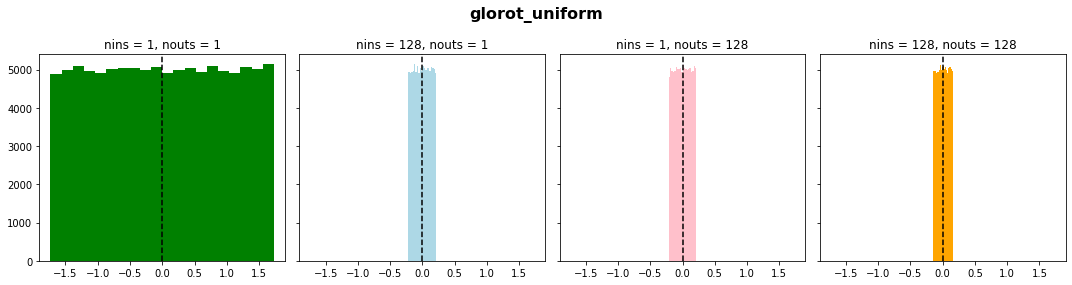

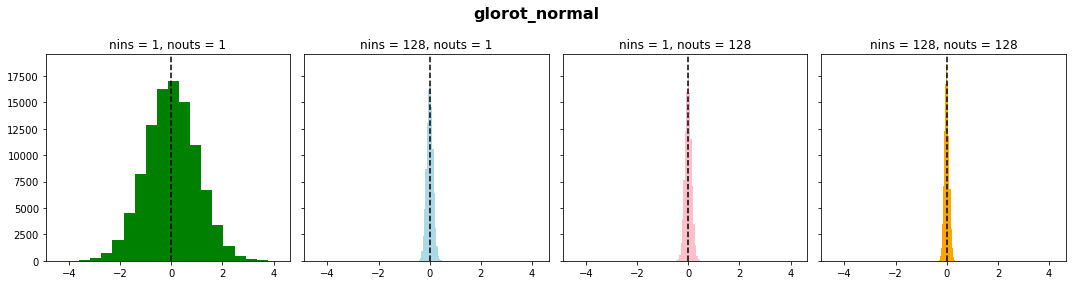

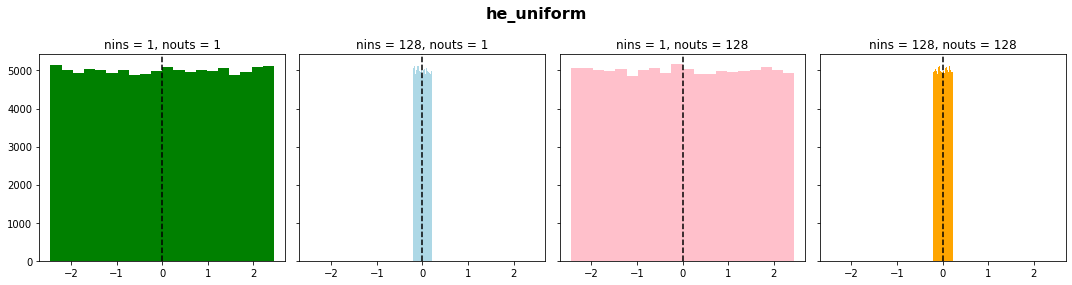

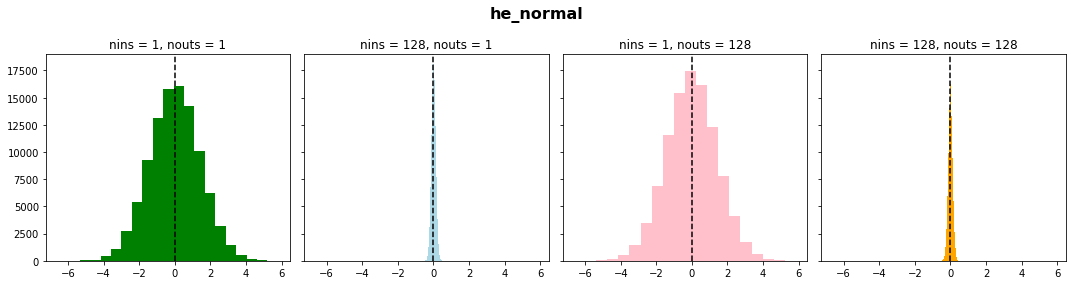

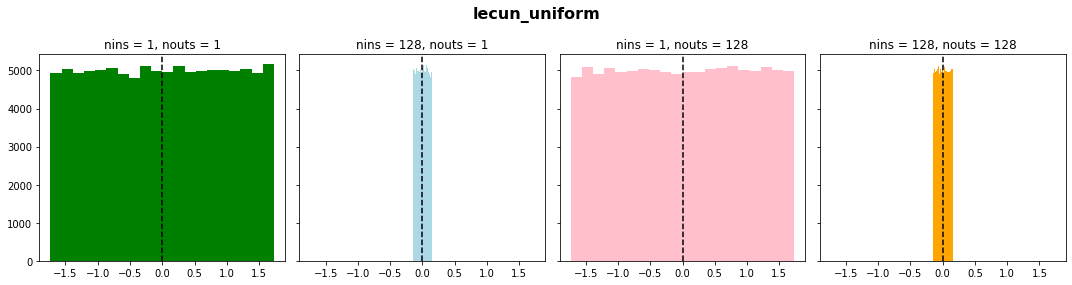

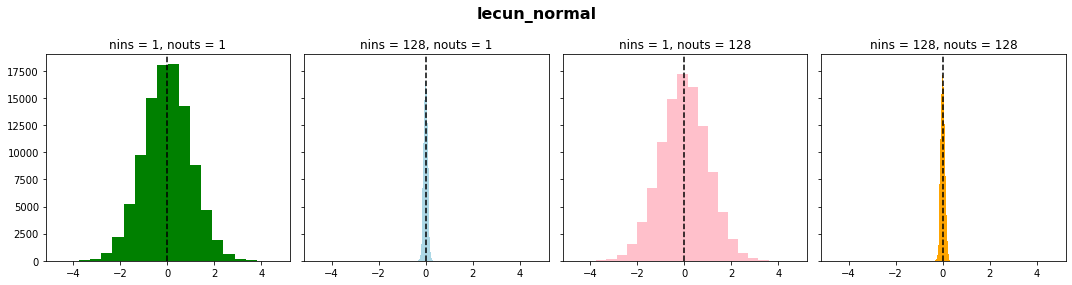

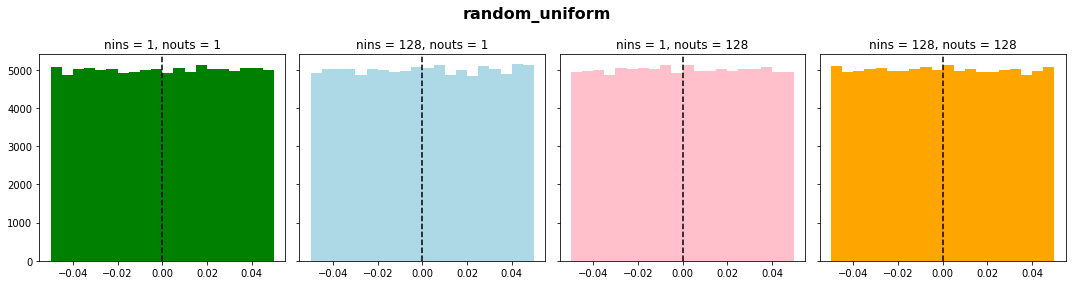

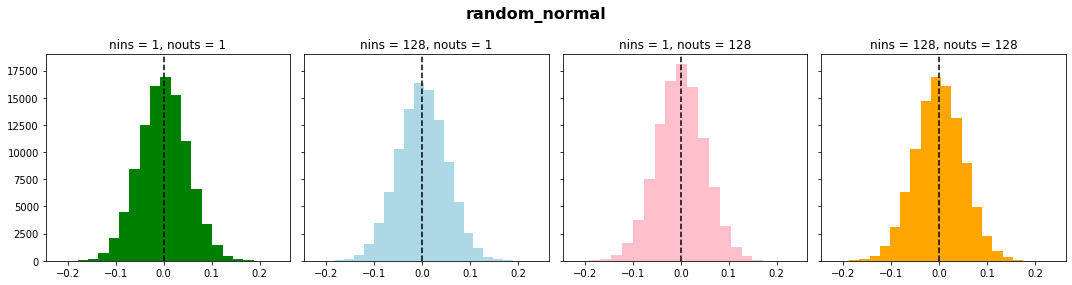

In [19]:
for initializer in I.__all__:
    plot_initializer(initializer, nins=128, nouts=128)

# Back to Dense Nodes

Now that we're back from our detour, let's rewrite our Node class with our Initializers replacing `random.random()`

In [20]:
# kaitorch/layers.py

class Node:

    def __init__(self, nin, nout, activation, initializer):

        self.w = [Scalar(initializer(nin, nout)) for _ in range(nin)]
        self.b = Scalar(initializer(nin, nout))
        self.a = activation

    def __call__(self, x):
        x = [x] if isinstance(x, Scalar) else x
        signal = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        if self.a and self.a != 'softmax':
            signal = signal.activation(self.a)
        return signal

    def parameters(self):
        return self.w + [self.b]

Let's also create a `Dense` class, representing a layer of dense nodes.

Each `Dense` layer has the following properties
- `nins` - number of inputs to the layer
- `nouts` - number of outputs of the layer (equal to the number of nodes or units in Keras terms)
- `nodes` - a list of `Node`s in the layer
- `activation` - the activation function of the layer
- `initializer` - the weight initializer of the layer

The `get_initializer` code should look familiar - it's the same logic as how we loaded the activation functions.
- If initializer is a `str`, check if it has been implemented in the `initializers.py` module
- If initializer is an `Initializer` object, we can directly use it.

```python
# Keras-esque 
Dense(units=64, initializer='random_normal')
Dense(units=64, initializer=initializers.RandomNormal())
```

In [21]:
# Writing this so the cell below doesn't throw an error, I'll introduce Module later

class Module:
    pass

In [22]:
# kaitorch/layers.py

class Dense(Module):
    
    def __init__(self, nouts, activation=None, initializer='glorot_uniform'):
        self.nins = None
        self.nouts = nouts
        self.nodes = None
        self.activation = activation
        self.initializer = self.get_initializer(initializer)

    def get_initializer(self, initializer):

        if isinstance(initializer, str):
            if initializer in I.__all__:
                return getattr(I, initializer)()
            else:
                raise Exception(
                    f'[Undefined Initializer] - Initializer "{initializer}" has not been implemented'
                )
        elif isinstance(initializer, Initializer):
            return initializer
        else:
            raise Exception(
                '[Undefined Initializer] - Object passed was not a str or Initializer'
            )
            
    def __repr__(self):
        repr_str = f'Dense(units={self.nouts}'
        if self.activation is not None:
            repr_str += f', activation={self.activation}'
        if self.initializer is not None:
            repr_str += f', initializer={self.initializer}'
        return repr_str + ')'


Dense.Node = Node

Since we don't know how many inputs a layer will have until we define all the layers of our model, we implement a `__build__` method that
- Sets the number of inputs `nins` of each layer to be the `nouts` of the previous layer
- Creates our list of Dense nodes that comprise the Dense layer.

In [23]:
# kaitorch/layers.py

def __build__(self, nins):
    self.nins = nins
    self.nodes = [
        self.Node(self.nins, self.nouts, self.activation, self.initializer)
        for _ in range(self.nouts)
    ]
    
Dense.__build__ = __build__

Finally, we add `parameters` to return all the nodes in a layer, and `__call__` to perform the neuron calculation described earlier.

$$ \text{output} = \text{Dense}(\text{inputs}) = \text{Activation}(\text{bias} + \sum_{\text{i}}^{\text{num_inputs}} \text{input}_i * \text{weight}_i) $$

<br><center><i>also, I forgot if I mentioned it earlier but neuron and node are interchangeable</center></i>


In [24]:
# kaitorch/layers.py

def __call__(self, x):
    outs = [n(x) for n in self.nodes]
    if self.activation == 'softmax':
        outs = getattr(A, self.activation)(outs)
    return unwrap(outs)

def parameters(self):
    return [p for node in self.nodes for p in node.parameters()]

Dense.__call__ = __call__
Dense.parameters = parameters

# Sequential Class - Creating a Model

Now that we have a dense layer, let's start building our `Sequential` model class.

- `unwrap` recursively "unwraps" nested lists of length 1 until it gets an object which is either a non-list or a list of length > 1

In [25]:
# kaitorch/utils.py

def unwrap(out):

    if isinstance(out, list):
        if len(out) == 1:
            out = out[0]
            out = unwrap(out)
    return out

Our Keras-esque `Sequential` class will be comprised of a linear stack of layers (currently we just have `Dense`).

We will store each layer as a list in `self.layers`, and the size of each layer in `self.layer_sizes`.

In [26]:
class Sequential(Module):

    def __init__(self, layers=None):
        self.built = False

        self.layers = layers if layers else []
        self.layer_sizes = [layer.nouts for layer in self.layers] if self.layers else []
        
    # kaitorch/models.py

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Even though we can add the layers we want when initializing our Sequential class, let's also add an `add()` method for adding layers to the model.

In [27]:
# kaitorch/models.py

def add(self, layer):

    self.layers.append(layer)
    self.layer_sizes.append(layer.nouts)

Sequential.add = add

Since we're dealing with a linear stack of layers, we can perform the forward pass by sequentially calling each layer.

In [28]:
def __call__(self, x):
    for layer in self.layers:
        x = layer(x)
    return unwrap(x)

Sequential.__call__ = __call__

You might recall that in our `Dense` layer, only `self.nouts` was defined, while `self.nins` was initialized as `None` because the number of inputs to a layer is dependent on the outputs of the previous layer (the "previous layer" of the first layer is the input data).

Once we're ready to build our model, we can use the `self.layer_sizes` variable with the input size appended to the front will make it easy for us to assign the `self.nins` of each layer. We calculate this with `self.build()`.

In [29]:
'''
I'm not sure if this visualization helps but given 4 dense layers with nouts 3, 4, 4, 1,
We can get the nins of each layer by starting with the input size, followed by the nouts sequence.

nouts:    [3] [4] [4] [1]   # the last output size is unused
             \   \   \
nins: [input] [3] [4] [4]
'''

def build(self, input_size):

    if self.built:
        return

    self.layer_sizes.insert(0, input_size)

    for idx, layer in enumerate(self.layers):
        layer.__build__(self.layer_sizes[idx])

    self.built = True
    
Sequential.build = build

Adding in some printing functionality

In [30]:
# kaitorch/models.py

def __repr__(self):
    print([layer.parameters() for layer in self.layers])
    return '\n'.join(str(layer) for layer in self.layers)

def summary(self):
    print('_' * 115)
    print('Layer (params)' + ' '*59 + 'Output Shape' + ' '*5 + 'Params = Weights + Biases')
    print('=' * 115)
    for layer_num, layer in enumerate(self.layers):
        l_name = layer.__repr__()
        l_output = f'(None, {layer.nouts})'
        l_params = len(layer.parameters())
        l_w = l_params - layer.nouts if l_params > 0 else 0
        l_b = layer.nouts if l_params > 0 else 0

        print(f'{l_name:<73}{l_output:<17}{l_params:<9}{l_w:<10}{l_b:<6}')
        if layer_num != (len(self.layers) - 1):
            print('_' * 115)
    print('=' * 115)
    print(f'Total Params: {sum([len(layer.parameters()) for layer in self.layers])}')
    print('_' * 115)

def plot(self, filename=None):

    if not self.built:
        raise Exception('[Model Not Built] - Use Sequential.build(input_size) to build model')
    empty_input = self.__call__([0]*self.layer_sizes[0])
    return plot_model(empty_input, filename=filename)

Sequential.__repr__ = __repr__
Sequential.summary = summary
Sequential.plot = plot

# __Building a Multi-layer Perceptron__

We have all we need to build an MLP! We'll continue adding functionality to our `Sequential` class in the next few notebooks, but this will do for now.

__We can define our model like this__

In [31]:
model = Sequential([
    Dense(3, activation='tanh', initializer='he_uniform'),
    Dense(4, activation='tanh', initializer='he_uniform'),
    Dense(4, activation='tanh', initializer='he_uniform'),
    Dense(1, activation='tanh', initializer='he_uniform')
])

In [32]:
model.build(3)
model.summary()

___________________________________________________________________________________________________________________
Layer (params)                                                           Output Shape     Params = Weights + Biases
Dense(units=3, activation=tanh, initializer=he_uniform)                  (None, 3)        12       9         3     
___________________________________________________________________________________________________________________
Dense(units=4, activation=tanh, initializer=he_uniform)                  (None, 4)        16       12        4     
___________________________________________________________________________________________________________________
Dense(units=4, activation=tanh, initializer=he_uniform)                  (None, 4)        20       16        4     
___________________________________________________________________________________________________________________
Dense(units=1, activation=tanh, initializer=he_uniform)                 

__or like this__

In [33]:
model = Sequential()
model.add(Dense(3, activation='tanh', initializer='he_uniform'))
model.add(Dense(4, activation='tanh', initializer='he_uniform'))
model.add(Dense(4, activation='tanh', initializer='he_uniform'))
model.add(Dense(1, activation='tanh'))

In [34]:
model.build(3)
model.summary()

___________________________________________________________________________________________________________________
Layer (params)                                                           Output Shape     Params = Weights + Biases
Dense(units=3, activation=tanh, initializer=he_uniform)                  (None, 3)        12       9         3     
___________________________________________________________________________________________________________________
Dense(units=4, activation=tanh, initializer=he_uniform)                  (None, 4)        16       12        4     
___________________________________________________________________________________________________________________
Dense(units=4, activation=tanh, initializer=he_uniform)                  (None, 4)        20       16        4     
___________________________________________________________________________________________________________________
Dense(units=1, activation=tanh, initializer=glorot_uniform)             

__Plotting our model__

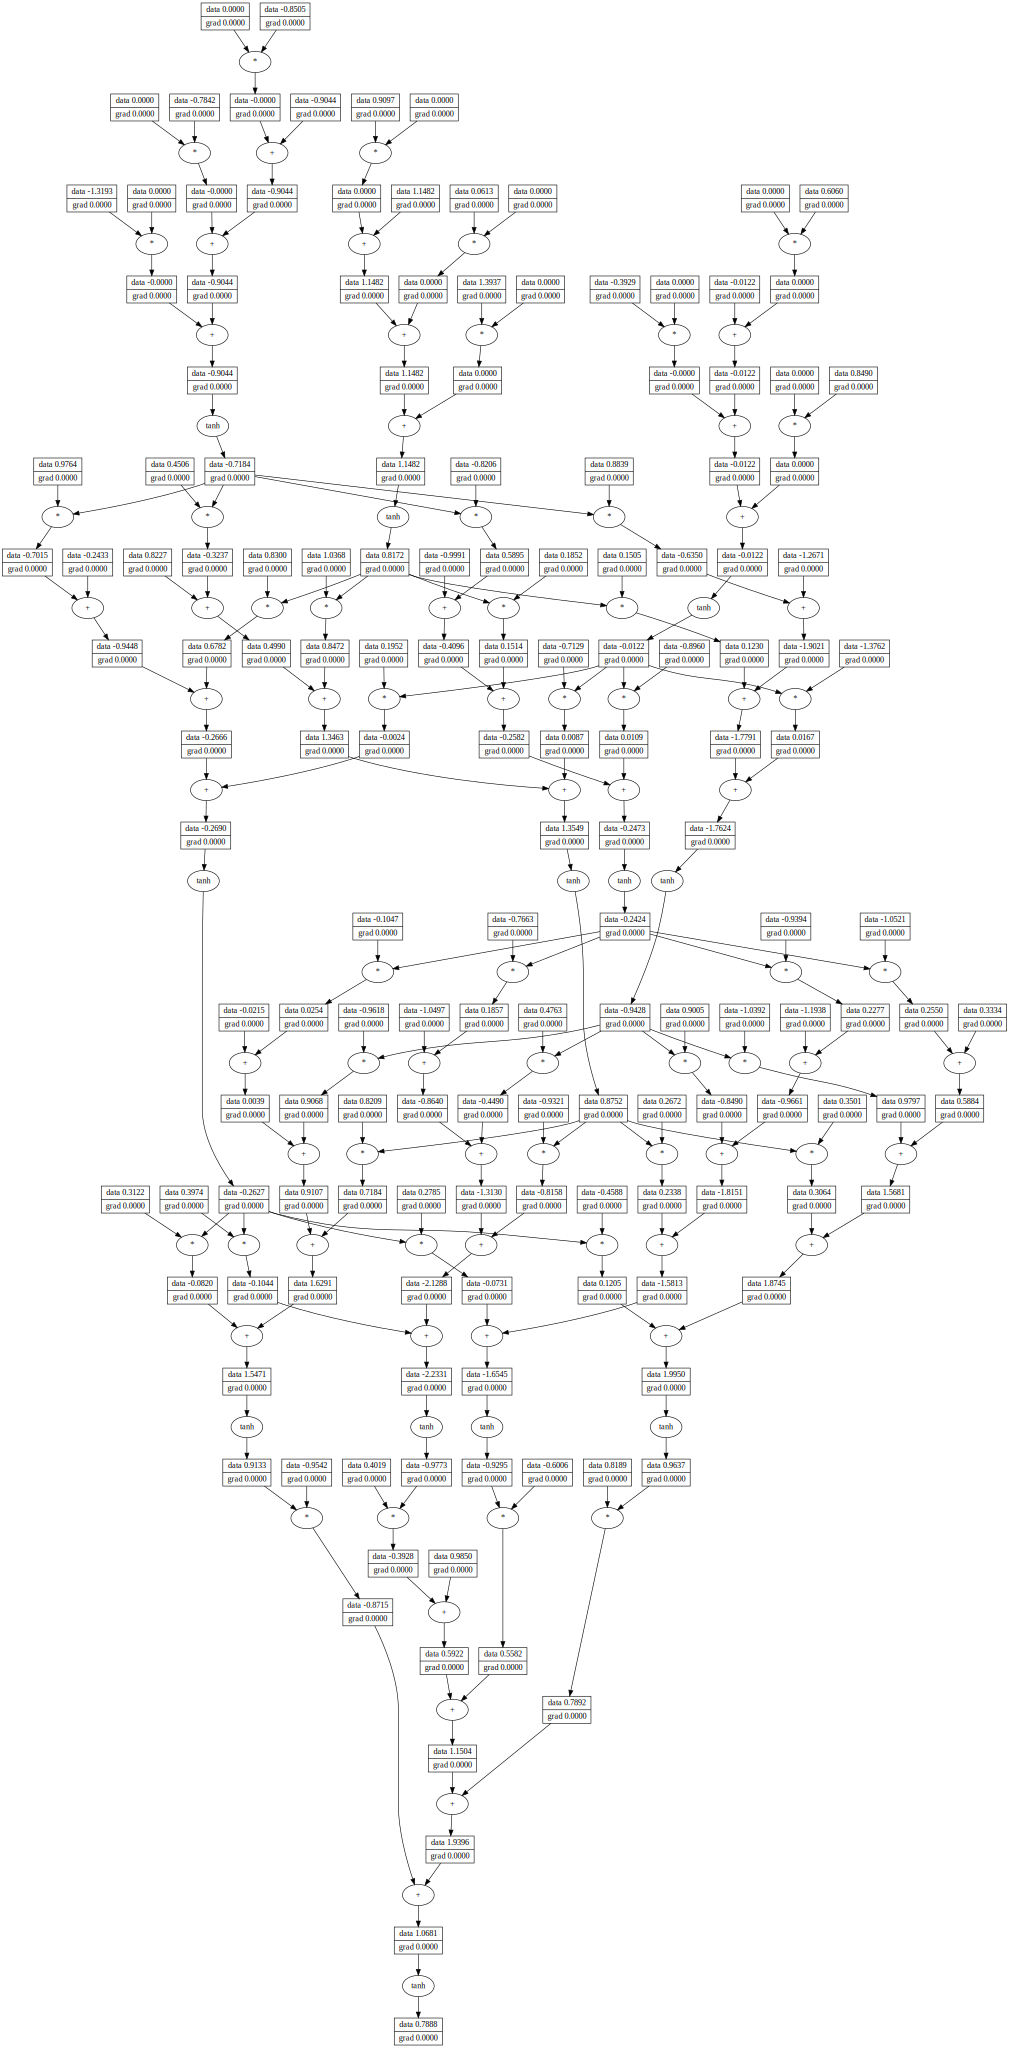

In [35]:
from kaitorch.graph import plot_model

model.plot(filename='./imgs/notebook_04_model')

# Training our Multi-Layer Perceptron

First we'll define some dummy data, consisting of 5 data samples, each with an input of length 3 and a single output of either 1 or -1.

In [36]:
xs = [[ 2.0,  3.0, -1.0],
      [ 3.0, -1.0,  0.5],
      [-0.5,  1.0,  1.0],
      [ 1.0,  1.0, -1.0],
      [ 2.5, -1.0, -1.0]]

ys = [1.0, -1.0, -1.0, 1.0, -1.0]

We'll eventually build out a more sophisticated training loop, but for purposes of understanding the training process lets write it as a for loop first.

For each iteration

 - 1) __Input Samples__ 
     - Feed input inputs into the model and perform a forward pass to get the predicted values.

 - 2) __Calculate Loss__ 
     - We'll use a simple maximum-margin hinge loss for binary classification. This is squared error where the labels are `-1 or 1`.

 - 3) __Zero Gradients__
     - Manually set the gradients of all parameters to zero. If not done, the gradients for each Scalar value will accumulate during model training, which may lead to undesired behaviour. The PyTorch equivalent is `zero_grad()`.

 - 4) __Reverse-mode Autodiff__
     - Begin backpropogation by performing a backward pass to calculate the gradients of every parameter (weight & bias) in the model.

 - 5) __Gradient Descent__
     - Complete backpropogation by updating the parameter values of the model, each parameter will be adjusted by a `learning_rate` (set to 0.1) multiplied by the negative of the gradient. We'll go deeper into gradient descent in notebook 6.

In [37]:
for k in range(50):
    
    # 1
    ypred = [model(x) for x in xs]
    
    # 2
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # 3
    for p in model.parameters():
        p.grad = 0.0

    # 4
    loss.backward()
    
    # 5
    for p in model.parameters():
        p.data += 0.1 * -1 * p.grad
        
    print(f'Epoch {k:<2} | Loss: {loss.data:.8f}')

Epoch 0  | Loss: 9.68964668
Epoch 1  | Loss: 7.48656195
Epoch 2  | Loss: 2.97017453
Epoch 3  | Loss: 0.23045534
Epoch 4  | Loss: 0.09829837
Epoch 5  | Loss: 0.05394757
Epoch 6  | Loss: 0.03501915
Epoch 7  | Loss: 0.02460277
Epoch 8  | Loss: 0.01822441
Epoch 9  | Loss: 0.01402010
Epoch 10 | Loss: 0.01109652
Epoch 11 | Loss: 0.00897946
Epoch 12 | Loss: 0.00739706
Epoch 13 | Loss: 0.00618377
Epoch 14 | Loss: 0.00523382
Epoch 15 | Loss: 0.00447694
Epoch 16 | Loss: 0.00386485
Epoch 17 | Loss: 0.00336349
Epoch 18 | Loss: 0.00294821
Epoch 19 | Loss: 0.00260085
Epoch 20 | Loss: 0.00230776
Epoch 21 | Loss: 0.00205850
Epoch 22 | Loss: 0.00184503
Epoch 23 | Loss: 0.00166103
Epoch 24 | Loss: 0.00150149
Epoch 25 | Loss: 0.00136243
Epoch 26 | Loss: 0.00124060
Epoch 27 | Loss: 0.00113337
Epoch 28 | Loss: 0.00103860
Epoch 29 | Loss: 0.00095449
Epoch 30 | Loss: 0.00087957
Epoch 31 | Loss: 0.00081259
Epoch 32 | Loss: 0.00075253
Epoch 33 | Loss: 0.00069848
Epoch 34 | Loss: 0.00064971
Epoch 35 | Loss: 0.0

After 50 epochs (each epoch is a pass of the entire dataset through model training), our loss is pretty close to 0 and it looks like our model has learned our 5 datapoints! Lets look at the predictions to confirm this:

In [38]:
ypred = [round(model(x).data, 3) for x in xs]
ypred

[0.994, -0.994, -0.99, 0.993, -0.994]

In [39]:
ys

[1.0, -1.0, -1.0, 1.0, -1.0]

__Pretty close!__

If you call `model.plot()` after training, you'll see the graph of the neural net with all of its gradients before they are zerod. 

- Earlier in the training process, you'll see larger gradients as larger updates are being made.

- Later in the training process, the gradients will be relatively small since the model is already fit pretty closely to the data.

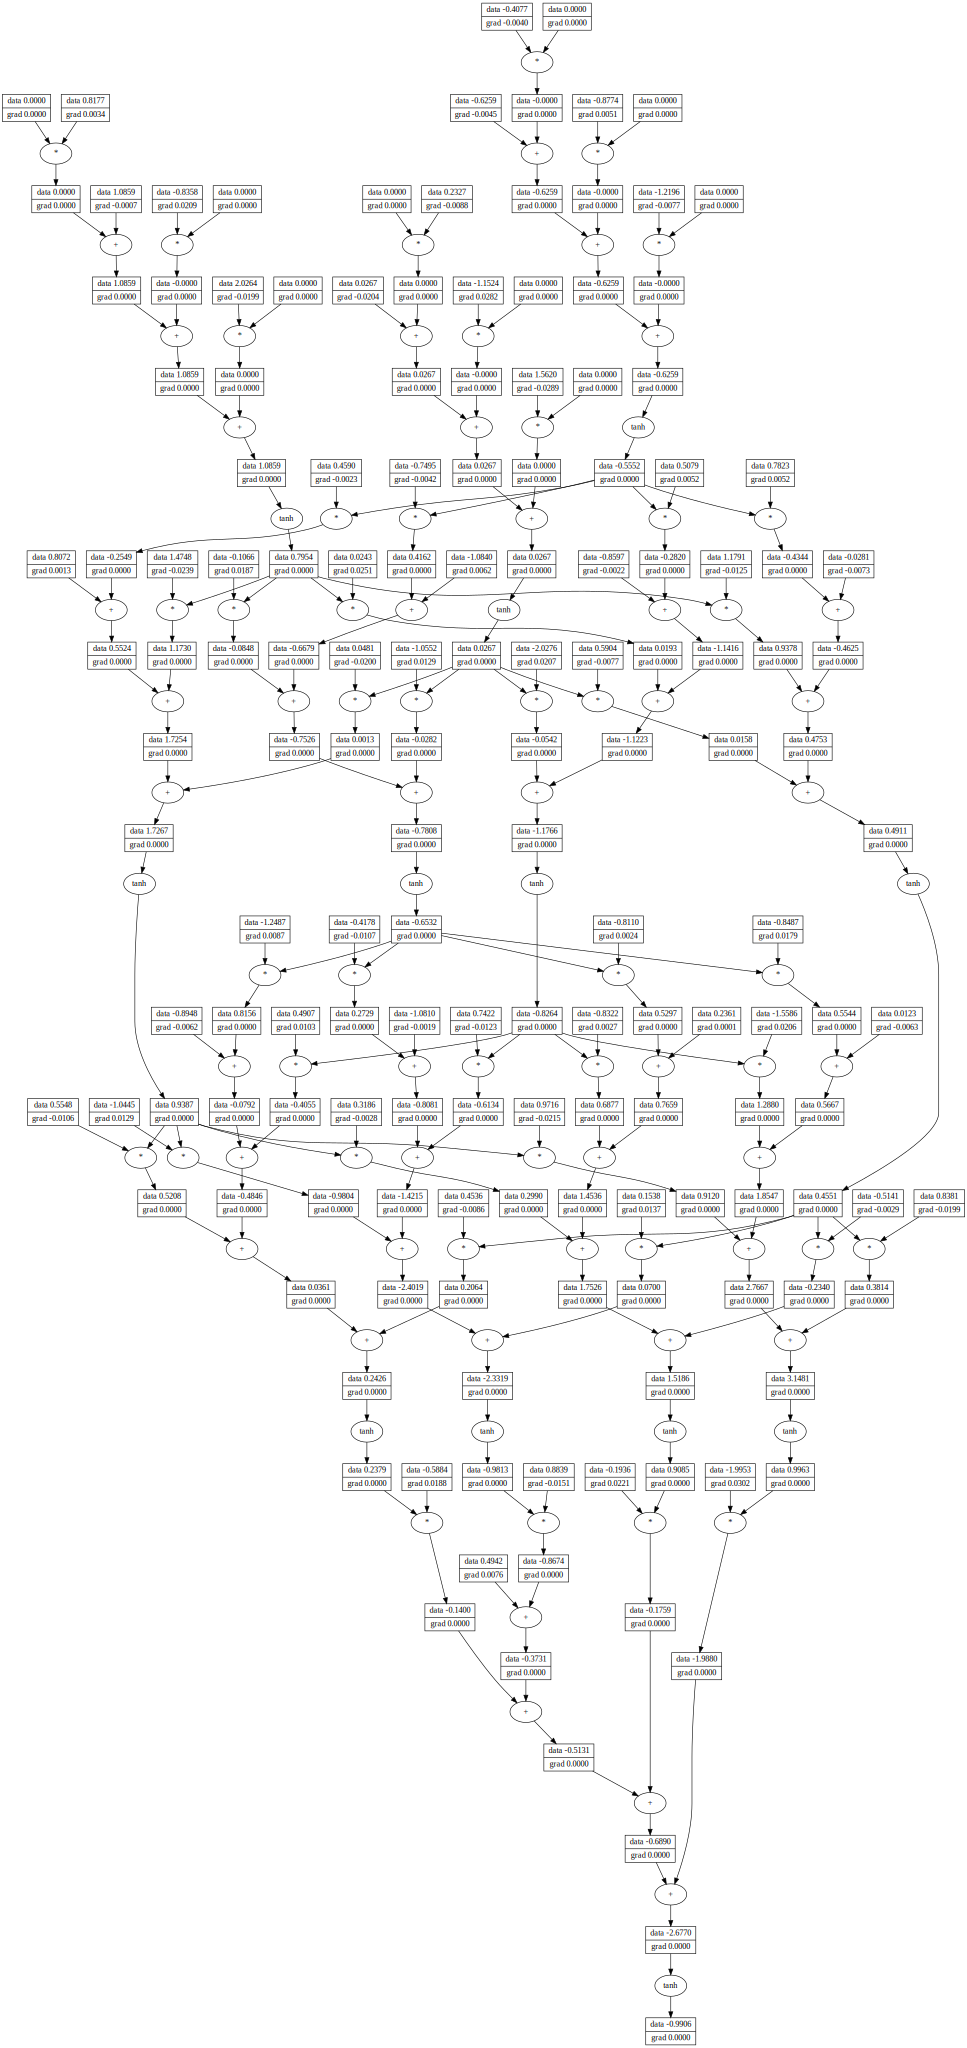

In [40]:
model.plot(filename='./imgs/notebook_04_model')

We're not done with our `Sequential` class yet, but this notebook is getting pretty long so I'll end it here :)